<a href="https://colab.research.google.com/github/JamKia/Fractional-Gaussian-Noise/blob/main/Fractional_Gaussian_Noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import matplotlib.pyplot as plt
import pprint
import pandas as pd
import datetime
import missingno as msno
from stochastic.noise import FractionalGaussianNoise
from tqdm import tqdm_notebook

In [ ]:
import os
folder_name = 'output-fGn'
current_dir = os.getcwd()
print(current_dir)
path = current_dir+'/'+folder_name+'/'
os.makedirs(path, exist_ok=True)

/home/jamshid/Dropbox/Mapping Coupled Timeseries onto network/6- peer reviewed-DJIA-S&P500-SSEC


In [ ]:
Hurst_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [ ]:
def fGn_DataSource(Hurst, max_ensemble_no = 32, length = 2000):

    def fGn(Hurst, length = length, t=1):
        from stochastic.noise import FractionalGaussianNoise
        fgn = FractionalGaussianNoise(Hurst, t)
        array_series = fgn.sample(n=length+1 , algorithm='hosking')
        return array_series
    
    
    df_fGn = pd.DataFrame()
    for ensemble_no in range(0,max_ensemble_no):
        df_fGn['no_'+str(ensemble_no)] = pd.Series(fGn(Hurst= Hurst, length= length, t=1))
        df_fGn['no_'+str(ensemble_no)+'_lag'] = df_fGn['no_'+str(ensemble_no)].shift(1)
            
    df_fGn.dropna(axis=0, inplace=True)
    df_fGn.reset_index(inplace=True, drop=True)
            
    return df_fGn

############################################################################
def AdjMatrix_list(df, numBins = 60, max_ensemble_no = 32):

    def Cross_jointProbability(df,column_name1, column_name2, numBins = numBins):
        import numpy as np
        jointProbs, edges = np.histogramdd([df[column_name1],
                                            df[column_name2]],
                                            bins = numBins)
        jointProbs /= jointProbs.sum()
        return jointProbs
    
#     print(len(df.columns))
    AdjMatrix_list = []
    
    for ensemble_no in range(0, max_ensemble_no):
        print('column_name1 = no_'+ str(ensemble_no))
        print('column_name1 = no_'+ str(ensemble_no)+'_lag')

        AdjMatrix_list += [Cross_jointProbability(df,
                               column_name1 = 'no_'+ str(ensemble_no),
                               column_name2 = 'no_'+ str(ensemble_no)+'_lag')
                              ]
        
    return AdjMatrix_list

###########################################################################
    

# OOP fGn Codes

In [ ]:
class CLASS_timeSeries():
    def __init__(self, series_name, path):
        self.series_name = series_name
        self.path = path
    def fGn(self, Hurst, length, column_name = 'logChange', t=1):
        self.Hurst = Hurst
#         self.series_name = 'H='+str(float(self.Hurst))
        from stochastic.noise import FractionalGaussianNoise
        fgn = FractionalGaussianNoise(Hurst, t)
        self.array_series = fgn.sample(n=length+1 , algorithm='hosking')
        self.df = pd.DataFrame({column_name:self.array_series})
        #---- lagged
        self.df_lag = pd.DataFrame()
        self.df_lag[column_name] = self.df[column_name].shift(1).copy()
        self.df_lag.dropna(axis=0,inplace=True)
        self.df_lag.reset_index(inplace=True)
        
        self.df = self.df.reindex(self.df.index.drop(0)).reset_index(drop=True)
        self.df.to_pickle(self.path+'df_'+self.series_name+'.pickle')
        self.df_lag.to_pickle(self.path+'df_'+self.series_name+'_lag.pickle')
#         print(len(self.df), len(self.df_lag))
#         self.df[column_name].head().plot()
#         plt.show()
#         self.df_lag[column_name].head().plot()
#         plt.show()
#         print(self.df[column_name].head())
#         print(self.df_lag[column_name].head())
    def Sample(self,length=9):

        edge_list=[]
        fig= plt.figure(figsize=(6,4))

        series1 = np.random.randint(48, 54, length)
        series2 = np.random.randint(48, 54, length)

        ax= plt.scatter(x=np.arange(1,length+1), y=series1, marker='o', color='r', alpha=0.5, label='Timeseries 1')
        ax= plt.scatter(x=np.arange(1,length+1), y=series2, marker='+', color='b', alpha=1, label='Timeseries 2')

        for i in np.arange(1,length+1):
            if series1[i-1] == series2[i-1]:
                edge_list+=['Loop']

            else: edge_list+=['Edge']

        for i in np.arange(1,length+1):
            if edge_list[i-1]=='Loop':
                ax= plt.text(i, 54, edge_list[i-1], color='green' ,bbox=dict(facecolor='w', alpha=1))
            else:
                ax= plt.text(i, 54, edge_list[i-1], color='violet' ,bbox=dict(facecolor='w', alpha=1))

        plt.xlim([0.5, 10])
        plt.ylim([47.5, 55])

        plt.yticks([])
        plt.grid()
        plt.xticks(np.arange(1, length+1), rotation=0)
        plt.title("Connection Type in Mapping from Timeseries onto Network")
        plt.ylabel('Timeseries Amplitude')
        plt.xlabel("Sample Datapoints")
        plt.legend(loc='lower right')
        plt.tight_layout()

        return ax

    def input_df(self, df):
        self.df = df
        return self.df
    
    def df_to_xlsx(self):
        # Create a Pandas Excel writer using XlsxWriter aui7js the engine.
        writer = pd.ExcelWriter(self.path+self.series_name+".xlsx", engine='xlsxwriter')  # io.excel.xlsx.writer
        # Convert the dataframe to an XlsxWriter Excel object.
        self.df.to_excel(writer)
        # Close the Pandas Excel writer and output the Excel file.
        writer.save()
        # print is successfully done!!!'
    
    def readExcel_series(self,fileName,column_name, length = 2000):
        df_0 = pd.read_excel(
            '/home/jamshid/Dropbox/spectral analysis of mapping time series onto complex networks/database/2009-2019/'+
            self.series_name+'.xlsx')
        #msno.matrix(df_0)

        df_0.interpolate(method ='linear', inplace=True)
        df_0[column_name].replace('null', np.nan, inplace=True)
        df_0[column_name].replace(0, np.nan, inplace=True)        
        #msno.matrix(df_0)
        df_0.fillna({column_name:np.nan}, inplace=True)
        msno.matrix(df_0)
        df_0[column_name].astype('float', inplace=True)
        df_0["logChange"] = np.log(df_0[column_name]/df_0[column_name].shift(1))
        df_0.dropna(inplace =True, how ="any") #inplace=True,
        df_0.reset_index(inplace=True)
        
#         df_0["logChange"] = (df_0["logChange"]-df_0["logChange"].mean())/df_0["logChange"].std()

        df_0['datetime']=pd.to_datetime(df_0['Date'])
        #df_0.set_index('datetime',inplace=True)
        df_0.drop(['Date'],axis=1,inplace=True)
        self.df = df_0.iloc[-length::].reset_index().copy()
        print(self.series_name+"\'s length:    ",len(self.df))
        self.df.to_pickle(self.path+'df_'+self.series_name+'.pickle')
        return self.df

    def PLOT_series(self, title ,column_name="logChange"):
        fig_series = plt.figure(figsize=(5,3))
        ax = plt.plot(self.df[column_name], linewidth = 0.2)
        plt.grid()
        plt.title(title)
        plt.tight_layout()
        fig_series.savefig(self.path+self.series_name+'_series.png', dpi=100)
        return ax
        
    def Autocorrelation(self, max_lag, column_name):
        self.max_lag= max_lag
        self.array_series = np.asarray(self.df[column_name])
        list_ret = np.zeros( (max_lag-1, len(self.array_series)-max_lag) )
        #print(list_ret,"\n","row=",max_lag-1,"col=",len(self.array_series)-max_lag)
        for i in range(1,max_lag):
#             print("##################\n",i)
#             print("\n\t timeseries:\n",
#                   self.time_series)
#             print("\n\t timeseries[i:]:\n",
#                   self.time_series[i:])
            ti = (self.array_series[i:] - self.array_series[:len(self.array_series)-i])
            ti = ti[:len(ti)-max_lag+i]
#             print("\n\t time_series[:len(time_series)-i]: \n",
#                   self.time_series[:len(self.time_series)-i])
#             print("\n\t time_series[i:] - time_series[:len(time_series)-i]: \n",
#                   self.time_series[i:] - self.time_series[:len(self.time_series)-i])
#             print("\n\t [:-max_lag+i]:",-self.max_lag+i)
#             print("\n\t ti=\n",(self.time_series[i:] - self.time_series[:len(self.time_series)-i])[:-self.max_lag+i])

#             print("\n\t np.mean(ti):\n",np.mean(ti))
            ti -= np.mean(ti)
#             print("\n\t ti= \n",ti)

#             print("\n\t np.std(ti):\n",np.mean(ti))
            ti /= np.std(ti)
#             print("\n\t ti=\n",ti)

            list_ret[i-1] = ti
#             print("\n\n list_ret[i-1] = ti \n",list_ret[i-1])
            
        n = list_ret.shape[1]
#         print("n=",n)

#         plt.plot(list_ret.T)
#         plt.title(self.series_name+" with lags untill "+str(max_lag))
#         plt.show()
            
        self.autocorr = (list_ret @ list_ret.T)/n
        #print("corr:\n",np.float16(self.corr))

        return self.autocorr
    
    def PLOT_Autocorrelation(self, title):
        fig_autocorrelation = plt.figure(figsize=(5,5))
        imshow =plt.imshow(self.autocorr, vmin=0, vmax=1)
        plt.colorbar(shrink=0.85)
        plt.xticks(np.arange(0,self.max_lag-1,10))
        plt.yticks(np.arange(0,self.max_lag-1,10))
        plt.title(title)
        fig_autocorrelation.savefig(self.path+self.series_name+'_AC_matrix.png', dpi=100)
        

#### fGn Auto-correlation Matrix

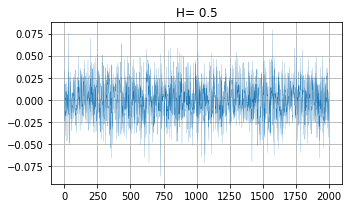

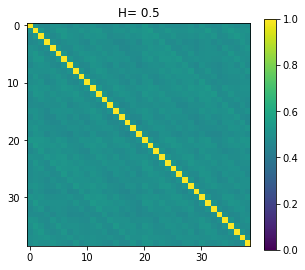

In [ ]:

###  fGn noise  ###############################################################
#==================
import os
folder_name = 'output-1-fGn-generate'
current_dir = os.getcwd()
path_to_load = current_dir+'/'+folder_name+'/'
os.makedirs(path_to_load, exist_ok=True)
#==================

noise_ObjectDicts={}
for Hurst in tqdm_notebook(Hurst_list):
    ensemble_no = 1
    while ensemble_no =<32:
    # making fGn object >>> 0: key: Hurst, value: object
    noise_ObjectDicts[Hurst+'_ensemble_no_'+ensemble_no] = [CLASS_timeSeries('H='+str(Hurst),path_to_load)]
    
    #2: key: Hurst, value: PLOT series
    noise_ObjectDicts[Hurst].append(
        noise_ObjectDicts[Hurst][0].fGn(Hurst,
                                        length= 2000,
                                        column_name="logChange",
                                        t=1))
    
    #3: key: Hurst, value: autocorrelation
#     noise_ObjectDicts[Hurst].append(
#         noise_ObjectDicts[Hurst][0].PLOT_series(title = 'H= '+str(Hurst), column_name="logChange"))
    
    #4: key: Hurst, value: PLOT autocorrelation
#     noise_ObjectDicts[Hurst].append(
#         noise_ObjectDicts[Hurst][0].Autocorrelation(max_lag =40,
#                                                     column_name='logChange'))
#     noise_ObjectDicts[Hurst].append(
#         noise_ObjectDicts[Hurst][0].PLOT_Autocorrelation(title = 'H= '+str(Hurst)))  
    
    noise_ObjectDicts[Hurst][0].df_to_xlsx()
    
    